## Final Project Submission

#### Authors: Brandon Sienkiewicz, Justin James, Zach Cherna

## Overview

## Data Understanding

The first step in the process is to clean the data and retrieve as much useful information as possible. The following section details the process of cleaning the data as well as creating some additional features that prove useful for analysis.

<span style="color:red">***This notebook utilizes geopandas and contextily which are not found in our base enviroment. They can be found and installed via the links provided below:***</span>


https://anaconda.org/conda-forge/contextily

`conda install -c conda-forge contextily`

https://geopandas.org/en/stable/getting_started/install.html

`conda install geopandas`

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression


%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7399300360   5/24/2022  675000.0         4        1.0         1180   
1  8910500230  12/13/2021  920000.0         5        2.5         2770   
2  1180000275   9/29/2021  311000.0         6        2.0         2880   
3  1604601802  12/14/2021  775000.0         3        3.0         2160   
4  8562780790   8/24/2021  592500.0         2        2.0         1120   

   sqft_lot  floors waterfront greenbelt  ... sewer_system sqft_above  \
0      7140     1.0         NO        NO  ...       PUBLIC       1180   
1      6703     1.0         NO        NO  ...       PUBLIC       1570   
2      6156     1.0         NO        NO  ...       PUBLIC       1580   
3      1400     2.0         NO        NO  ...       PUBLIC       1090   
4       758     2.0         NO        NO  ...       PUBLIC       1120   

  sqft_basement sqft_garage sqft_patio yr_built  yr_renovated  \
0             0           0         40     1969             0   
1          1570           0        240     1950             0   
2          1580           0          0     1956             0   
3          1070         200        270     2010             0   
4           550         550         30     2012             0   

                                             address        lat       long  
0  2102 Southeast 21st Court, Renton, Washington ...  47.461975 -122.19052  
1  11231 Greenwood Avenue North, Seattle, Washing...  47.711525 -122.35591  
2  8504 South 113th Street, Seattle, Washington 9...  47.502045 -122.22520  
3  4079 Letitia Avenue South, Seattle, Washington...  47.566110 -122.29020  
4  2193 Northwest Talus Drive, Issaquah, Washingt...  47.532470 -122.07188  

[5 rows x 25 columns]

First, we import all relevant packages and read in the data. Next, we will want to get some more information about the data.

In [3]:
df_map = df.copy()

df_map['loc'] = df_map[['long','lat']].values.tolist()

geometry = [Point(tuple(xy)) for xy in df_map['loc']]

To get an idea of the geographic distribution, we will use a map which references the longitude and latitude of each listed property. The first step in the process is to create a copy of the dataframe, create a column of lists containing the longitude and latitude, and the converting it into a geometric point object.

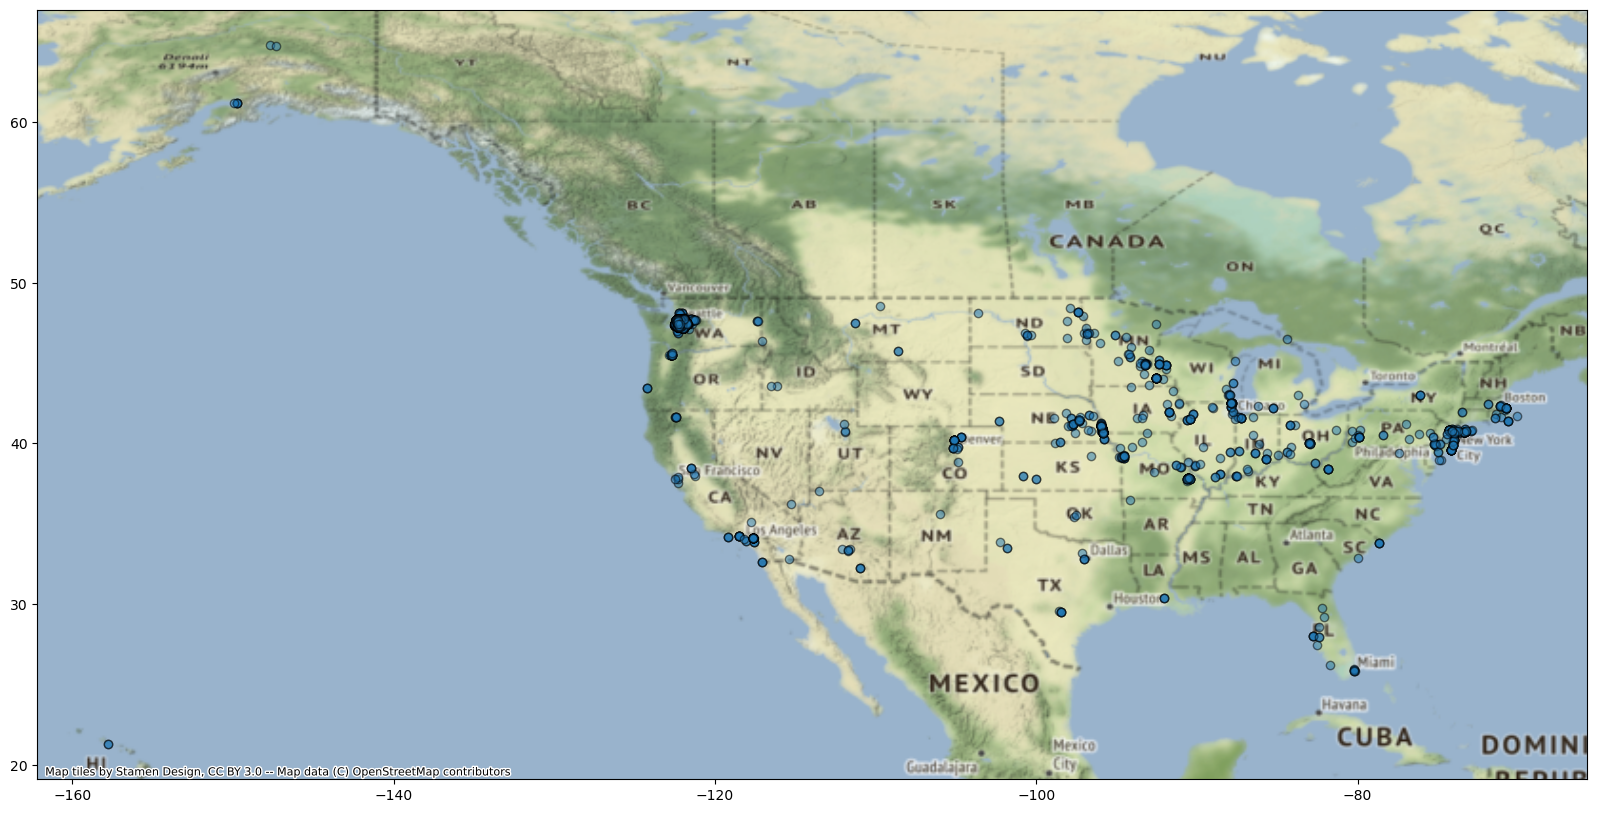

In [4]:
geo_df = gpd.GeoDataFrame(df_map,
                          crs="EPSG:4326",
                          geometry=geometry)
ax = geo_df.plot(figsize=(20, 20),
                 alpha=0.5,
                 edgecolor='k')
cx.add_basemap(ax, crs=geo_df.crs)

We then can create the GeoDataFrame and plot. We use contextily to add a basemap to our plot as well. It appears that the data provided is not limited to King County, but rather, contains home sales for areas around most of the US. It does appear that the majority of the data is within King County as there is a large clusting of points in Washington.

In [5]:
df_clean = df.dropna(inplace=True)

df_clean = df[(df.lat > 47.087) &
              (df.lat < 47.779) &
              (df.long > -122.527) &
              (df.long < -121.064)]

df_clean.reset_index(drop=True, inplace=True)

After some trial, the most efficient approach, limiting by the approximate latitude and longitude of the county, was chosen. This will give us only relevant properties. The null values are also dropped in this step.

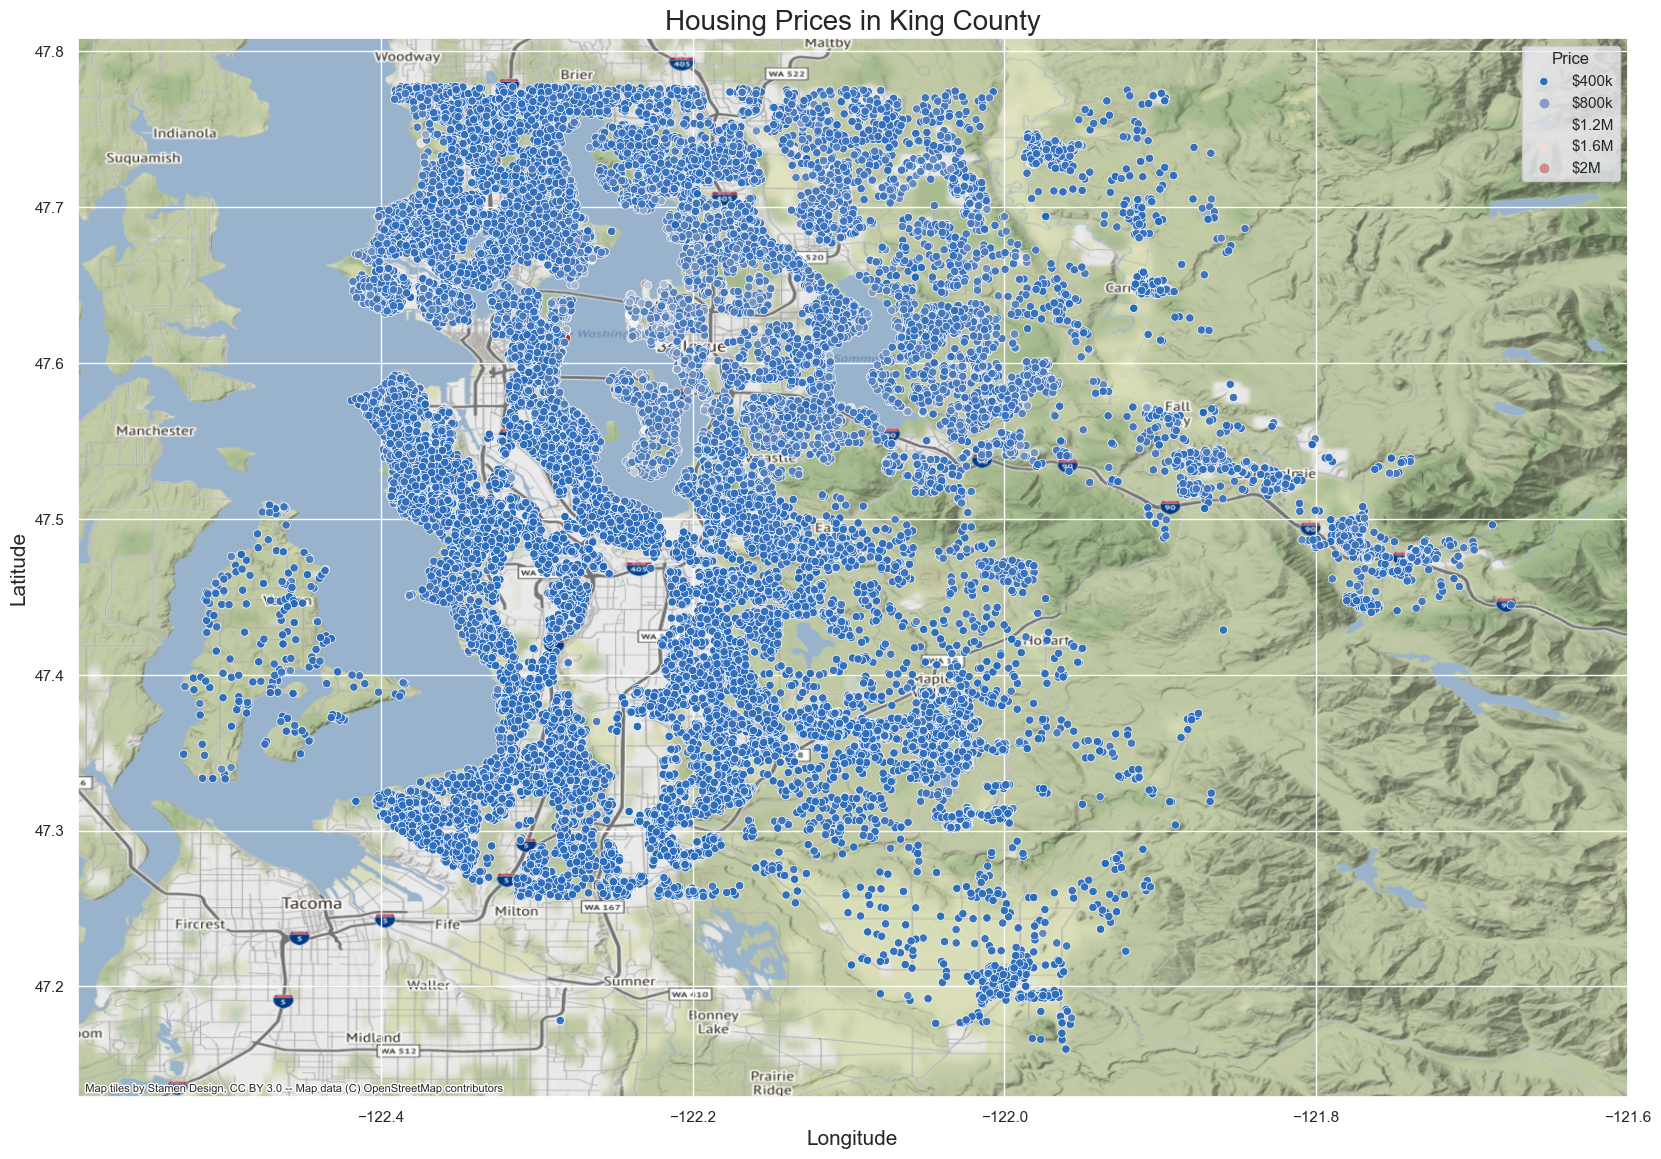

In [6]:
df_map = df_clean.copy()

sns.set(rc={'figure.figsize':(20,20)})

#Setting the figure size

df_map['loc'] = df_map[['long','lat']].values.tolist()
geometry = [Point(tuple(xy)) for xy in df_map['loc']]
geo_df = gpd.GeoDataFrame(df_map,
                          crs="EPSG:4326",
                          geometry=geometry)

#Creating the geometry point objects and the GeoDataFrame

ax = sns.scatterplot(data=geo_df,
                     x='long',
                     y='lat',
                     hue="price",
                     palette = 'vlag')

#Plotting the figure

cx.add_basemap(ax, crs=geo_df.crs)

#Adding a basemap

ax.set_xlabel('Longitude',
              fontdict={'fontsize': 15})
ax.set_ylabel('Latitude',
              fontdict={'fontsize': 15})
ax.set_title('Housing Prices in King County',
             fontdict={'fontsize': 20})
ax.legend(title='Price',
          labels=['$400k',
                  '$800k',
                  '$1.2M',
                  '$1.6M',
                  '$2M'])
plt.xlim(right=-121.6)
plt.savefig('images/kingcountymap', bbox_inches='tight', dpi=300);

#Labelling

# ******
# Important Note: The plot does not appear to run correctly when 
# using run all. Please re-run this cell to get the correct plot
# if all of the points are blue as this is an error
# ******

This map gives us a better idea of what is going on with housing prices in King County. The higher values are represented by the red sections while the lower are represented by blue. There generally appears to be a large distribution of high value properties in one area and the value appears to diminish as you move further away from this area. Now that there is a solid understanding of our target variable, the data can begin to be cleaned.

## Data Preparation

In [7]:
df_split = df_clean.address.str.replace(',', '').str.split(' ')

The first task is to pull out the zip codes from the address listed for each property. To achieve this, commas in `df_clean.address` were replaced with empty space and then the string was split by spaces.

In [8]:
zips = []
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for x in df_split:
    for y in x:
        if (y[0] == '9') & (len(y) == 5):
            zips.append(y)
for x in zips:
    if x[1] != '8':
        zips.remove(x)
df_clean['zip'] = pd.Series(zips)

A empty list, `zips` and a list of numbers `numbers` was defined. The entries were then looped over to find entries that started with a 9 and were length 5 as this is true for all zip codes in King County. The entries were looped over once more to find entries with a second number 8 as all entries within the county contain this. Any remaining values that did not meet this final criteria were removed. The zip codes were then added to the dataframe.

In [9]:
#Creaet dict of mean prices by zip code
zips_avg_prices = df_clean.groupby(df_clean.zip).mean()['price']
zip_mean_dict = zips_avg_prices.to_dict()

# Map mean proce by zip into new column
df_clean['zip_mean'] = df_clean['zip'].map(zip_mean_dict)
df_clean['zip_mean']

# Create zip price mean category column

price_cat = []

for price in df_clean['zip_mean']:
    if price < 714997.7:
        price_cat.append(1)
    elif price < 1320000:
        price_cat.append(2)
    else:
        price_cat.append(3)
        
df_clean['price_cat'] = price_cat

With the zip codes available, the next step was to find the mean property price per zip code and to assign them to different price categories. These catergories were added to the Dataframe in the `price_cat` column.

In [10]:
# Encode ordinals
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

data_categorical = pd.DataFrame(df_clean.select_dtypes("object")) \
.drop(['date','address'],axis=1)

ordinal_data = data_categorical[['view',
                                 'condition',
                                 'grade']]

Next, we want to convert the categorical columns to numeric columns in order to be able to use them in our analysis. To achieve this we create a new dataframe, `data_categorical` with the categorical data and then another new data frame, `ordinal_data` containing the ordinal categorical data.

In [11]:
view_ord_cats = [['NONE',
                  'FAIR',
                  'AVERAGE',
                  'GOOD',
                  'EXCELLENT']]

view_ords = OrdinalEncoder(categories=view_ord_cats)
view_ords.fit(pd.DataFrame(ordinal_data['view']))
view_encoded = view_ords.transform(pd.DataFrame(ordinal_data['view']))

view_enc = pd.DataFrame(view_encoded,
                        columns=['view_enc'])

We then define a list of the categories and convert these into ordinal data. This is done for each of the categorical columns `view`, `condition`, and `grade`. The process for `view` can be seen above and then the same process is applied to `condition` and `grade` below.


In [12]:
condition_ord_cats = [['Poor',
                       'Fair',
                       'Average',
                       'Good',
                       'Very Good']]

cond_ords = OrdinalEncoder(categories=condition_ord_cats)
cond_ords.fit(pd.DataFrame(ordinal_data['condition']))
cond_encoded = cond_ords.transform(pd.DataFrame(ordinal_data['condition']))

cond_enc = pd.DataFrame(cond_encoded,
                        columns=['cond_enc'])

In [13]:
grade_ord_cats = [['1',
                   '2 Substandard',
                   '3 Poor',
                   '4 Low',
                   '5 Fair',
                   '6 Low Average',
                   '7 Average',
                   '8 Good',
                   '9 Better',
                   '10 Very Good',
                   '11 Excellent',
                   '12 Luxury',
                   '13 Mansion']]

grade_ords = OrdinalEncoder(categories=grade_ord_cats)
grade_ords.fit(pd.DataFrame(ordinal_data['grade']))
grade_encoded = grade_ords.transform(pd.DataFrame(ordinal_data['grade']))

grade_enc = pd.DataFrame(grade_encoded,
                         columns=['grade_enc'])

In [14]:
# Create dummy columns of non-ordinal category data

cat_data = pd.DataFrame(df_clean.select_dtypes("object")).drop(['date',
                                                                'address',
                                                                'zip'],
                                                               axis=1)

cat_dums = pd.get_dummies(cat_data)
cat_dums = cat_dums.add_suffix('_dum')

Now that we have our numerical data, we creat dummy columns for the categorical data.

In [15]:
# Concatonate numerical and encoded features

# Concat ordinal dfs
ords_conc = pd.concat([view_enc,
                       cond_enc,
                       grade_enc],
                      axis=1)

# Get numerical data
data_numerical = df_clean._get_numeric_data()
data_numerical

#Concatonate all
concat_all = pd.concat([data_numerical,
                        ords_conc,
                        cat_dums,
                       df_clean.zip],
                       axis=1)

# Set df to new df (concat_all)
df_clean = concat_all

Finally, we concatonate all the new columns and add them to our DataFrame.

In [16]:
gr_above_avg = []
for x in df_clean['grade_enc']:
    if x > 7:
        gr_above_avg.append(1)
    else:
        gr_above_avg.append(0)
        
df_clean['gr_above_avg'] = pd.Series(gr_above_avg)

To narrow down the categorical variables, grade, condition, and view were changed into binary variables (above average or not above average). This was achieved with a simple nested loop.

In [17]:
cond_above_avg = []
for x in df_clean['cond_enc']:
    if x > 2:
        cond_above_avg.append(1)
    else:
        cond_above_avg.append(0)

df_clean['cond_above_avg'] = pd.Series(cond_above_avg)   

The above code is for condition.

In [18]:
view_above_avg = []
for x in df_clean['view_enc']:
    if x > 2:
        view_above_avg.append(1)
    else:
        view_above_avg.append(0)

df_clean['view_above_avg'] = pd.Series(view_above_avg)

The above code is for view.

In [19]:
df_clean['has_garage'] = [1 if x > 0 else 0 for x in df_clean['sqft_garage']]
df_clean['has_basement'] = [1 if x > 0 else 0 for x in df_clean['sqft_basement']]
df_clean['has_patio'] = [1 if x > 0 else 0 for x in df_clean['sqft_patio']]

We also converted some housing features to binary. After some experimenting, it appears that it is more impactful if the property has the feature or not rather than looking at what the square footage of the feature is.

In [20]:
df_clean['locat'] = list(zip(df_clean.long,
                             df_clean.lat))

Another interesting feature will be the distance from the zip code highest mean price as it seems that the housing prices go down the further away from the highest price zip code one gets (represented in the map in the data understanding section. To achieve this, first we must created a tuple of longitude and latitude.

In [21]:
def haversineHighZip(coord):
    lon, lat = coord
    lonS, latS = (-122.236572, 47.626480)
    
    R = 6371000  # radius of Earth in meters
    phi = math.radians(lat)
    phi_S = math.radians(latS)
    
    delta_phi = math.radians(latS - lat)
    delta_lambda = math.radians(lonS - lon)
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi) * math.cos(phi_S) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    km = (R * c) / 1000  # output distance in kilometers

    km = round(km, 3)

    return km

We can then define the haversine function to find the distance between the zip code with the highest price and any other property. The haversine function is ideal as it is used to find the distance between two points on a sphere. Initially, we used the distance to Seattle as it is a major city in King County. After some trial and error we found that the distance to the highest priced zip code gave better results and ended up being the one chosen for the final model.

In [22]:
distance = []
for x in df_clean.locat:
    distance.append(haversineHighZip(x))
df_clean['dist_high_zip'] = pd.Series(distance)

We then use the defined haversine function to find the distance to the zip code with the highest price from each property and create a column for this information.

In [23]:
# Remove outliers

# Create function that identifies outliers

def find_outliers_IQR(df_clean):
   q1=df_clean.quantile(0.25)
   q3=df_clean.quantile(0.75)
   IQR=q3-q1
   outliers = df_clean[((df_mod<(q1-1.5*IQR)) | (df_clean>(q3+1.5*IQR)))]
   return outliers

def get_outliers(df_df_clean):
    outliers = find_outliers_IQR(df_clean)
    print('number of outliers: '+ str(len(outliers)))
    print('max outlier value: '+ str(outliers.max()))
    print('min outlier value: '+ str(outliers.min()))
    return print(outliers)

# Remove rows with outliers from dataframe. Currently min outliers are hard coded below after running get_outliers function

df_less_outs = df_clean[df_clean['price'] < 2309000]
df_less_outs = df_less_outs[df_less_outs['sqft_living'] < 4450]
df_less_outs = df_less_outs[df_less_outs['sqft_above'] < 3950]
df_clean = df_less_outs

Functions are defined to remove any outliers. Once the outliers are removed the only remaining step is to remove irrelevant columns that will not be used in the modelling. These were determined based on their relevance, some analysis, and some trial and error.

In [24]:
df_model = df_clean.drop([
    'id',
    'lat',
    'long',
    'view_enc',
    'waterfront_NO_dum',
    'greenbelt_NO_dum',
    'nuisance_NO_dum',
    'view_AVERAGE_dum',
    'view_EXCELLENT_dum',
    'view_FAIR_dum',
    'view_GOOD_dum',
    'view_NONE_dum',
    'condition_Average_dum',
    'condition_Fair_dum',
    'condition_Good_dum',
    'condition_Poor_dum',
    'condition_Very Good_dum',
    'grade_11 Excellent_dum',
    'grade_10 Very Good_dum',
    'grade_12 Luxury_dum',
    'grade_13 Mansion_dum',
    'grade_2 Substandard_dum',
    'grade_3 Poor_dum',
    'grade_4 Low_dum',
    'grade_5 Fair_dum',
    'grade_6 Low Average_dum',
    'grade_7 Average_dum',
    'grade_8 Good_dum',
    'grade_9 Better_dum',
    'locat'
],axis=1)
df_model.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  \
0  675000.0         4        1.0         1180      7140     1.0        1180   
1  920000.0         5        2.5         2770      6703     1.0        1570   
2  311000.0         6        2.0         2880      6156     1.0        1580   
3  775000.0         3        3.0         2160      1400     2.0        1090   
4  592500.0         2        2.0         1120       758     2.0        1120   

   sqft_basement  sqft_garage  sqft_patio  ...  sewer_system_PUBLIC_dum  \
0              0            0          40  ...                        1   
1           1570            0         240  ...                        1   
2           1580            0           0  ...                        1   
3           1070          200         270  ...                        1   
4            550          550          30  ...                        1   

   sewer_system_PUBLIC RESTRICTED_dum    zip  gr_above_avg  cond_above_avg  \
0                                   0  98055             0               1   
1                                   0  98133             0               0   
2                                   0  98178             0               0   
3                                   0  98118             1               0   
4                                   0  98027             0               0   

   view_above_avg  has_garage  has_basement  has_patio  dist_high_zip  
0               0           0             0          1         18.616  
1               0           0             1          1         13.011  
2               0           0             1          0         13.863  
3               0           1             1          1          7.825  
4               0           1             1          1         16.183  

[5 rows x 38 columns]

The data has now been fully cleaned and is ready for modelling.

## Data Modelling

In [25]:
df_model.corr()['price'].map(abs).sort_values(ascending=False)[0:15]

price                  1.000000
zip_mean               0.635232
price_cat              0.600768
sqft_living            0.550074
grade_enc              0.536595
sqft_above             0.456631
gr_above_avg           0.431669
bathrooms              0.420699
dist_high_zip          0.396717
bedrooms               0.301194
sqft_patio             0.235885
sqft_garage            0.213603
floors                 0.210292
sqft_basement          0.204616
heat_source_Gas_dum    0.175061
Name: price, dtype: float64

To get an idea for a baseline model, we check the features with the highest correlation coefficient. We will use `zip_mean` for our baseline model as it has the highest correlation coefficient.

In [26]:
y = df_model['price']
X = sm.add_constant(df_clean['zip_mean'])

results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                 1.823e+04
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:40:34   Log-Likelihood:            -3.8121e+05
No. Observations:               26951   AIC:                         7.624e+05
Df Residuals:                   26949   BIC:                         7.624e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.819e+05   5285.936     53.325      0.000    2.72e+05    2.92e+05
zip_mean       0.6300      0.005    135.022      0.000       0.621       0.639
==============================================================================
Omnibus:                     2462.360   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5335.459
Skew:                           0.584   Prob(JB):                         0.00
Kurtosis:                       4.840   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The baseline model turns out to be okay. The r-squared value indicates that `zip_mean` accounts for about 40% of the variance in `price`; however, the high condition number indicates that they are likely multicollinear. This is not surprising as `zip_mean` is based on the mean prices.

In [27]:
y = df_model.price
X = sm.add_constant(df_clean
                    [[
                        'sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     7611.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:40:34   Log-Likelihood:            -3.7481e+05
No. Observations:               26951   AIC:                         7.496e+05
Df Residuals:                   26944   BIC:                         7.497e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.295e+05   8410.391     15.397      0.000    1.13e+05    1.46e+05
sqft_living          256.0461      2.488    102.901      0.000     251.169     260.923
price_cat           2.259e+05   2816.529     80.203      0.000     2.2e+05    2.31e+05
dist_high_zip      -9990.5213    180.420    -55.374      0.000   -1.03e+04   -9636.889
gr_above_avg        1.954e+05   5440.289     35.918      0.000    1.85e+05    2.06e+05
cond_above_avg      7.213e+04   3339.812     21.598      0.000    6.56e+04    7.87e+04
waterfront_YES_dum  2.402e+05   1.52e+04     15.815      0.000     2.1e+05     2.7e+05
==============================================================================
Omnibus:                     1826.565   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7715.452
Skew:                           0.203   Prob(JB):                         0.00
Kurtosis:                       5.589   Cond. No.                     1.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After some trial and error with models, we eventually reached the above model. This was done by starting with the feature with the highest coefficient of correlation and then iteratively adding new features. This resulted in a model with a fairly strong $r^2$ of 0.629; however, the condition number is fairly high at 19,900 which indicates there is a high amount of multicollinearity. Some feature engineering will be able to lower this number.

In [28]:
df_model['log_sqft_living'] = np.log(df_model.sqft_living)

In [29]:
y = df_model.price
X = sm.add_constant(df_model
                    [[
                        'log_sqft_living',
                        'price_cat',
                        'dist_high_zip',
                        'gr_above_avg',
                        'cond_above_avg',
                        'waterfront_YES_dum'
                    ]])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     7216.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:40:34   Log-Likelihood:            -3.7526e+05
No. Observations:               26951   AIC:                         7.505e+05
Df Residuals:                   26944   BIC:                         7.506e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.711e+06   3.35e+04    -80.993      0.000   -2.78e+06   -2.65e+06
log_sqft_living     4.437e+05   4586.352     96.754      0.000    4.35e+05    4.53e+05
price_cat           2.273e+05   2865.436     79.333      0.000    2.22e+05    2.33e+05
dist_high_zip      -9793.3316    183.367    -53.408      0.000   -1.02e+04   -9433.922
gr_above_avg        2.455e+05   5368.080     45.734      0.000    2.35e+05    2.56e+05
cond_above_avg       6.86e+04   3395.270     20.205      0.000    6.19e+04    7.53e+04
waterfront_YES_dum  2.586e+05   1.54e+04     16.745      0.000    2.28e+05    2.89e+05
==============================================================================
Omnibus:                     2771.146   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14650.008
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       6.539   Cond. No.                         477.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By doing a log transformation of `sqft_living` we get a model with a slightly lower $r^2$ value but a much lower condition number of 477. All of the features are statistically significant as well. This indicates that there is much less multicollinearity and provides us with a strong model. Additionally, the Durbin-Watson value is slightly lower than 2 which indicates that there is only a very slight negative correlation among the errors. Since the value is so close to 2, the errors are likely independent. The only remaining step is to check our assumptions.

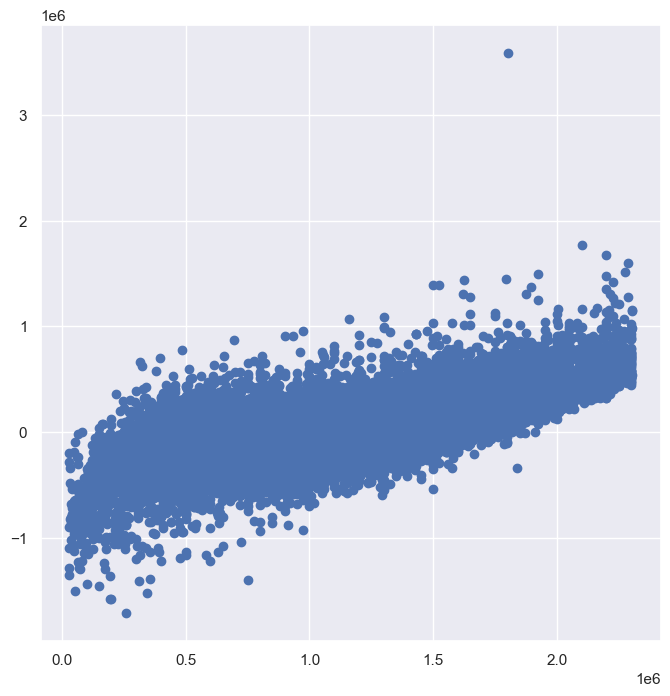

In [30]:
model_preds = model.predict(X)
resids = y - model_preds
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y, resids);

Overall, the above residual plot does not appear to be much more spread out in any section of the plot. This indicates that the data is likely homoskedastic or that the errors generally have the same variance.

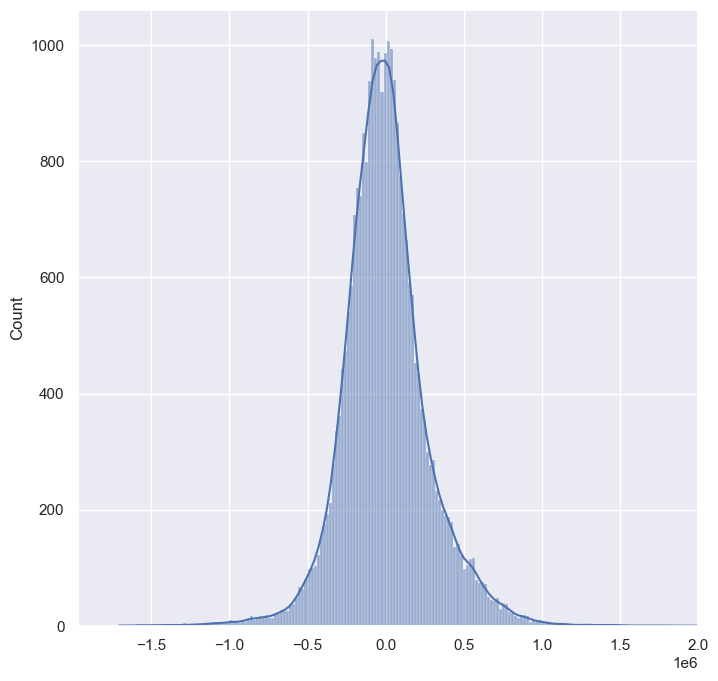

In [31]:
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.histplot(x=resids, kde=True)
plt.xlim(right=2000000);

After the log transformation of `sqft_living` the residuals appear to be normally distributed with a high kurtosis (~6.5 as seen in the above model).

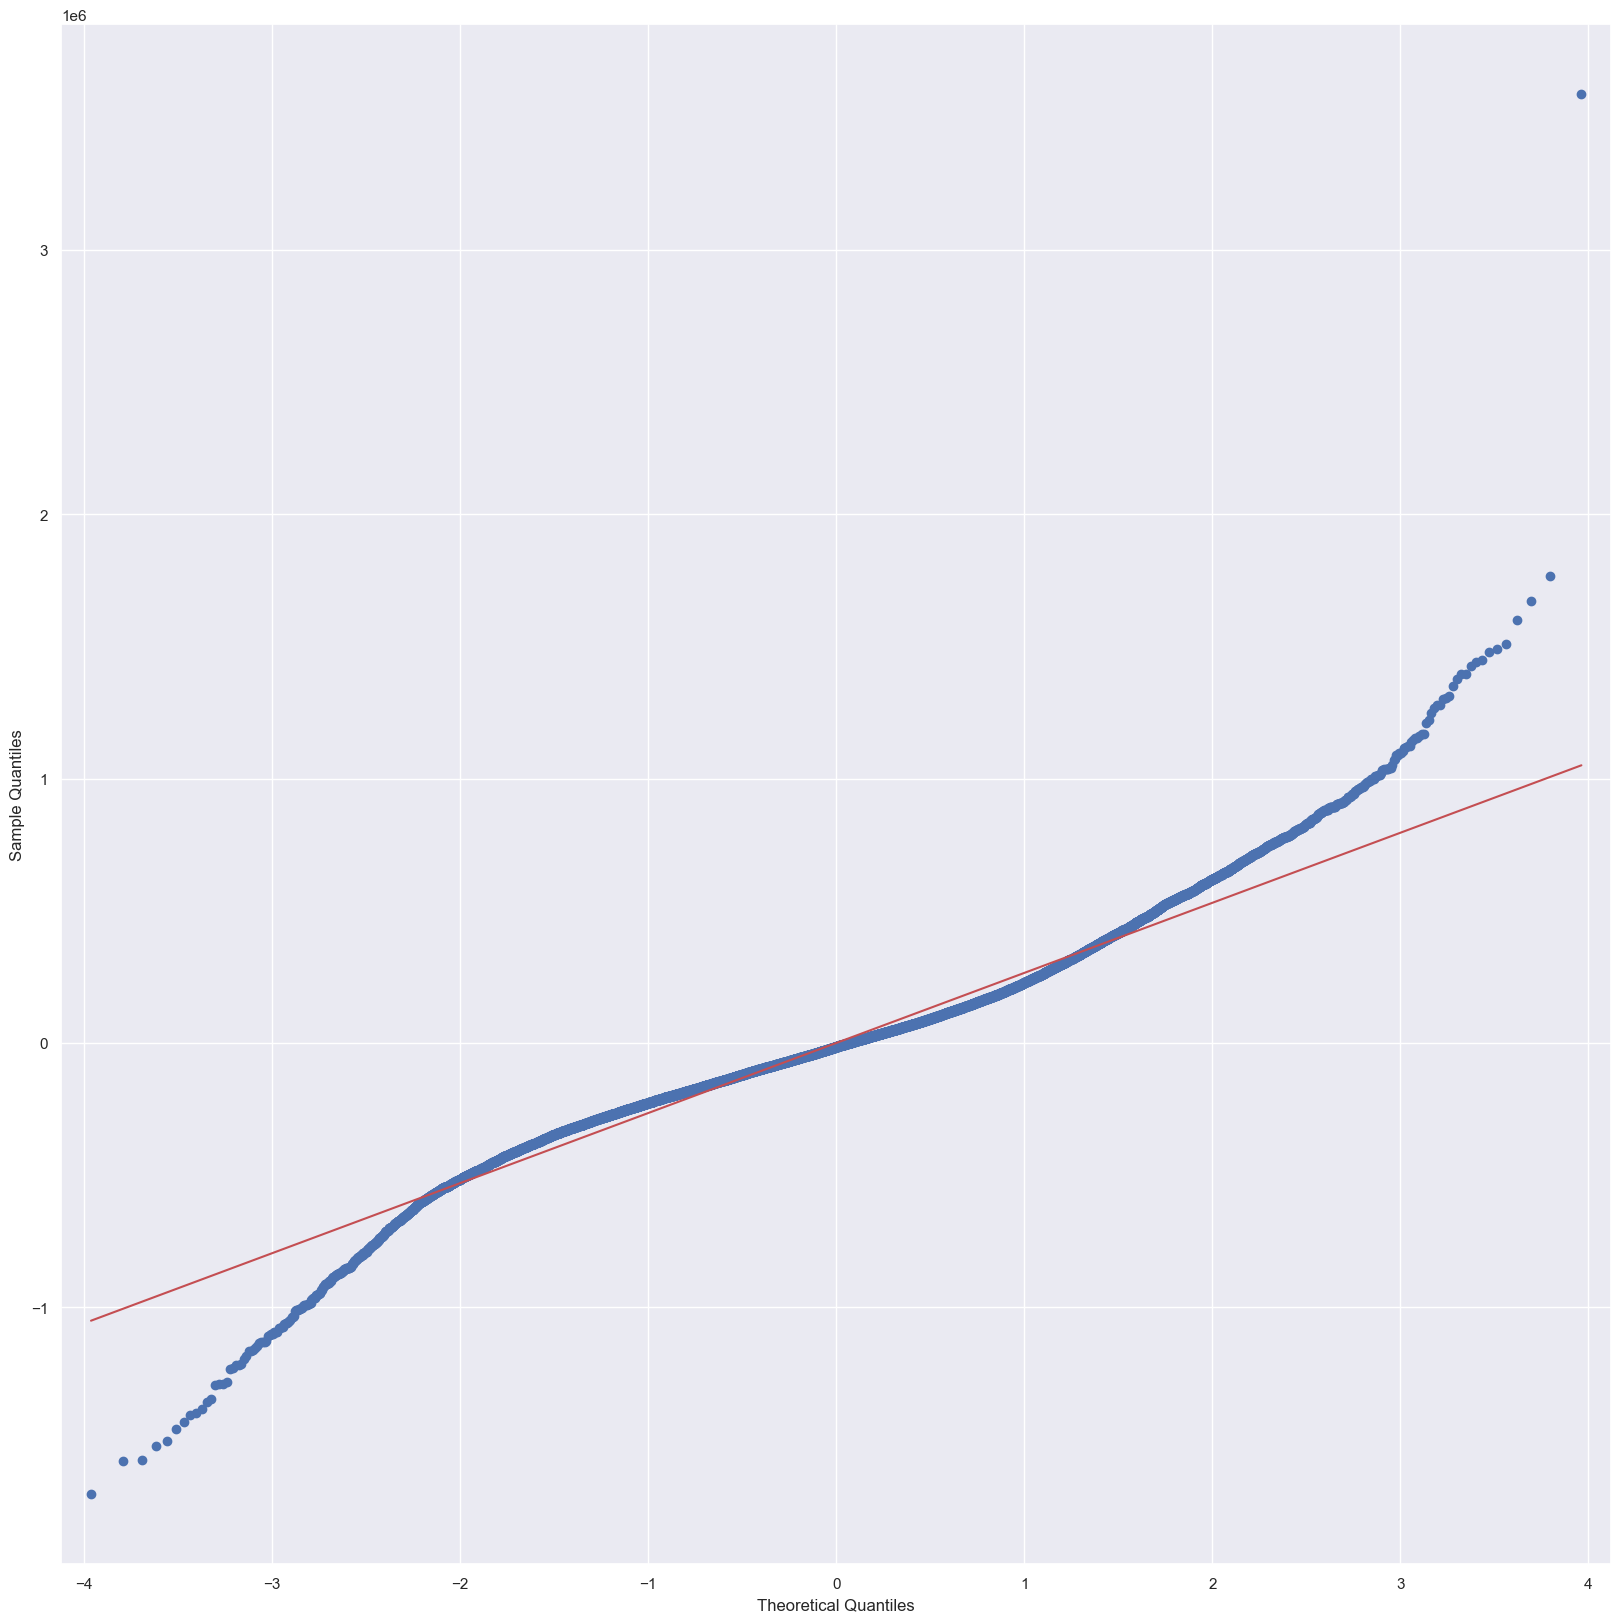

In [32]:
sm.qqplot(model.resid, line='r');

This plot shows that the data is over-dispersed. The data is more widely spread out around our central value than is typical for the normal distribution. This appears to be a characteristic of the housing market in King County as outliers were defined and removed. Trimming the data further could remedy this but it could take out some important data points.

In [33]:
df_final = df_model[[
    'log_sqft_living',
    'price_cat',
    'dist_high_zip',
    'gr_above_avg',
    'cond_above_avg',
    'waterfront_YES_dum']]

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif['feature'] = df_final.columns
vif["VIF"] = [variance_inflation_factor(df_final.values, i)
                          for i in range(len(df_final.columns))]

In [34]:
vif.sort_values('VIF',ascending=False)

feature        VIF
0     log_sqft_living  25.257603
1           price_cat  13.024246
2       dist_high_zip   6.093322
4      cond_above_avg   1.686581
3        gr_above_avg   1.231473
5  waterfront_YES_dum   1.023497

After looking at the variance inflation factors, it appears that `log_sqft_living` and `price_cat` are highly multicollinear features while `dist_high_zip` is fairly multicollinear. These results are not surprising as two of these values are based off of our dependent variable, `price`, and `log_sqft_living` is highly correlated with `price`.

After analysing all of the assumptions, the model appears to be pretty solid with a few minor issues (some multicollinearity and a high kurtosis). Care was taken to violate as little of the assumptions as possible and this model does a fair job of abiding to most assumptions.

While this is a good model, it does not do a great job of addressing our stakeholder. Most of the information present is not applicable to home renovations. Therefore; we sought to find another model that could help to advise renovations.

In [35]:
df_model['grade_squared'] = df_model['grade_enc']**2

y = df_model.price
X = sm.add_constant(df_model[[
    'price_cat',
    'grade_squared',
    'has_basement', 
    'has_patio', 
    'has_garage',  
    'floors',
    'bedrooms',
    'bathrooms',
    'cond_enc'
                       ]])

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     3836.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:40:36   Log-Likelihood:            -3.7705e+05
No. Observations:               26951   AIC:                         7.541e+05
Df Residuals:                   26941   BIC:                         7.542e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.544e+05   1.18e+04    -47.057      0.000   -5.77e+05   -5.31e+05
price_cat      2.967e+05   2635.948    112.561      0.000    2.92e+05    3.02e+05
grade_squared  1.182e+04    183.109     64.576      0.000    1.15e+04    1.22e+04
has_basement    3.63e+04   3778.482      9.608      0.000    2.89e+04    4.37e+04
has_patio      1.711e+04   4337.751      3.945      0.000    8608.076    2.56e+04
has_garage    -5.296e+04   4129.186    -12.825      0.000   -6.11e+04   -4.49e+04
floors        -2.397e+04   4046.444     -5.923      0.000   -3.19e+04    -1.6e+04
bedrooms       4.793e+04   2265.465     21.156      0.000    4.35e+04    5.24e+04
bathrooms      7.064e+04   3370.318     20.960      0.000     6.4e+04    7.72e+04
cond_enc       5.254e+04   2592.241     20.266      0.000    4.75e+04    5.76e+04
==============================================================================
Omnibus:                     2102.186   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5708.824
Skew:                           0.442   Prob(JB):                         0.00
Kurtosis:                       5.075   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model does a better job of showing the correlation between relevant renovation features and our target of `price`. This model has a $r^2$ of 0.562 which is lower than the above model but does a better job of relating to our business question. All of the features are statisically significant, the condition number is fairly low at 311, and the Durbin-Watson statistic indicates that the errors are likely independent. This model also has a lower kurtosis than the previous, 5 compared to 6.5.

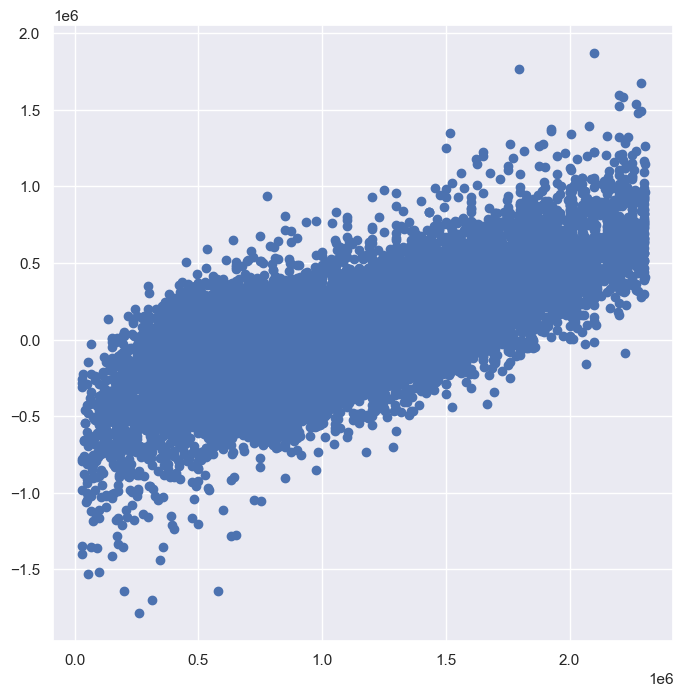

In [36]:
model_preds = model.predict(X)
resids = y - model_preds
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y, resids);

Overall, the above residual plot does not appear to be much more spread out in any section of the plot. This indicates that the data is likely homoskedastic or that the errors generally have the same variance.

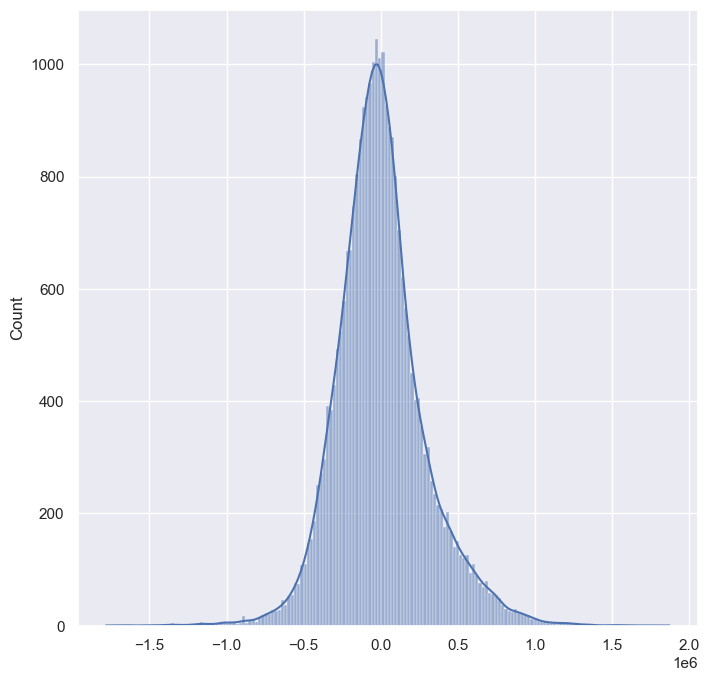

In [37]:
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.histplot(x=resids, kde=True);

The distribution looks to be fairly normally distributed with a slight right skew. The kurtosis is high which was mentioned in the regression model above.

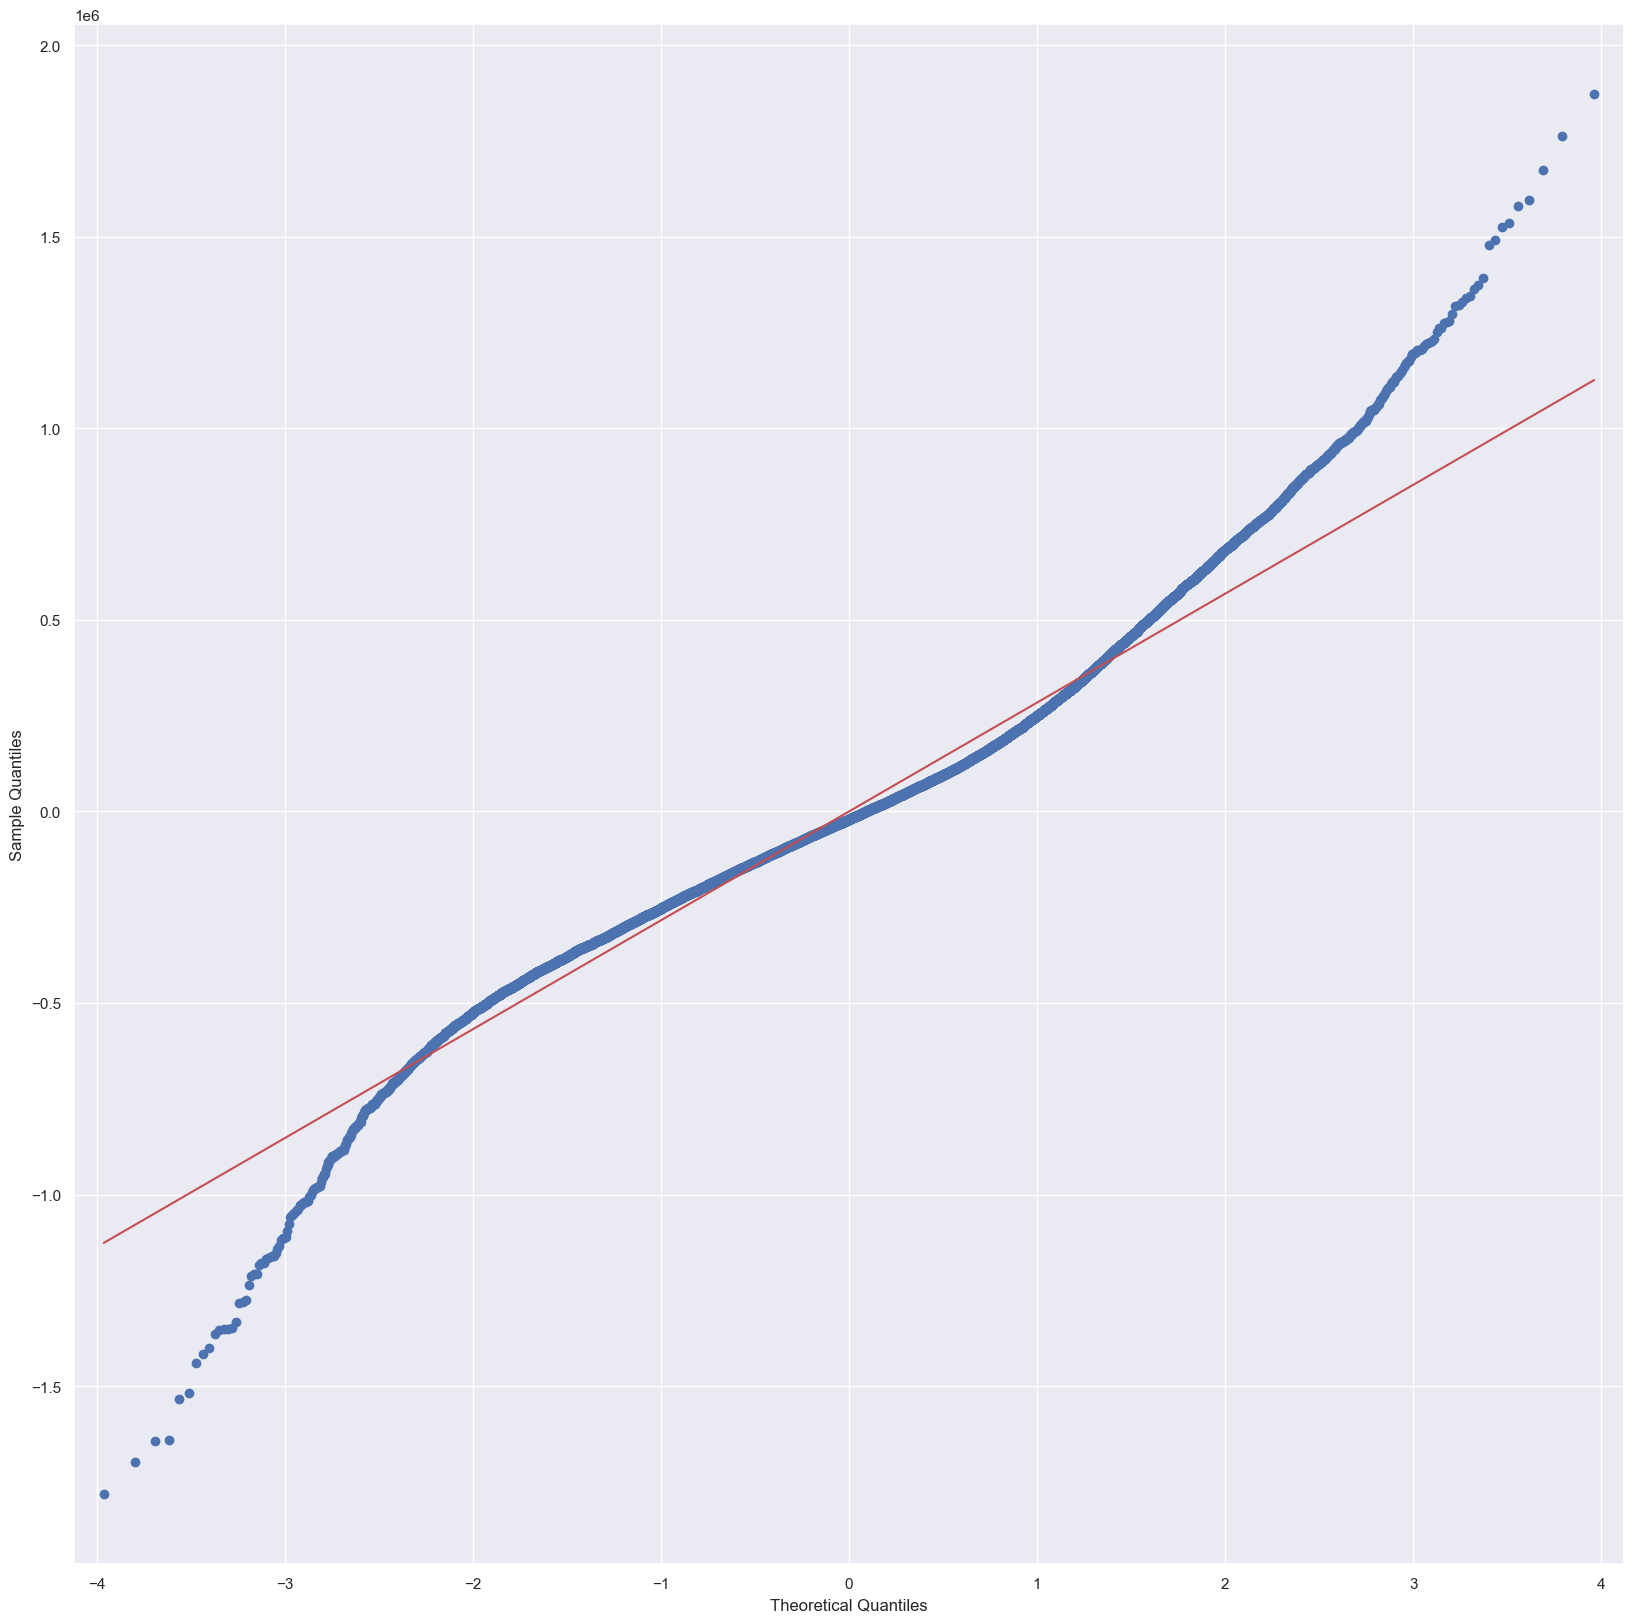

In [38]:
sm.qqplot(model.resid, line='r');

Similarly to the previous plot, this plot shows that the data is over-dispersed. The data is more widely spread out around our central value than is typical for the normal distribution. Trimming the data further could remedy this but it could take out some important data points.

In [39]:
df_final = df_model[[
    'price_cat',
    'grade_squared',
    'has_basement', 
    'has_patio', 
    'has_garage',  
    'floors',
    'bedrooms',
    'bathrooms',
    'cond_enc']]

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif['feature'] = df_final.columns
vif["VIF"] = [variance_inflation_factor(df_final.values, i)
                          for i in range(len(df_final.columns))]

In [40]:
vif.sort_values('VIF',ascending=False)

feature        VIF
1  grade_squared  21.240428
7      bathrooms  19.941812
6       bedrooms  17.847236
5         floors  11.379220
0      price_cat   8.888275
8       cond_enc   8.757735
3      has_patio   4.613503
4     has_garage   3.639737
2   has_basement   2.151993

This model has much more multicollinearity than the previous one, with 6 features having high variance inflation factors. This is to be expected as many of the categories relate to eachother in some way. Overal, this is a good model that does not violate too many assumptions and gives us valuable information to inform our stakeholders on home renovations. Now that we have a more useful model we can evaluate the results.

## Evaluation

The following visualization were created based off information gained from our above models. The features that are used were shown to have a relationship to the price and; therefore, should be explored further.

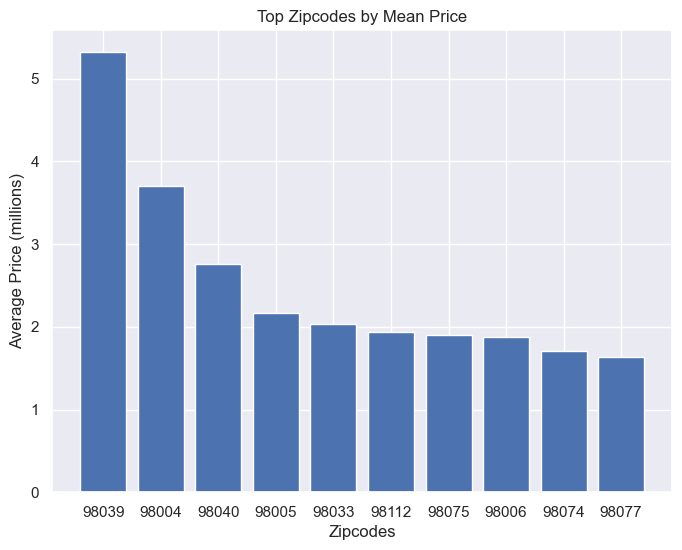

In [43]:
zip_info = df_clean[['zip', 'zip_mean']].drop_duplicates()
zip_top_10 = zip_info.sort_values('zip_mean', ascending=False)[0:10]
zip_top_10

fig, ax = plt.subplots(figsize=(8,6))

x = zip_top_10['zip']
y = zip_top_10['zip_mean']/1000000

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Average Price (millions)")
ax.set_title("Top Zipcodes by Mean Price")

ax.bar(x,y);

The above visualization shows the top zipcodes by price. This is based off of our first model and helps us to understand the housing market of King County. This shows that there are some distinct zip codes that have higher pricing than average.

In [44]:
zip_bot_10 = zip_info.sort_values('zip_mean', ascending=True)[0:10]

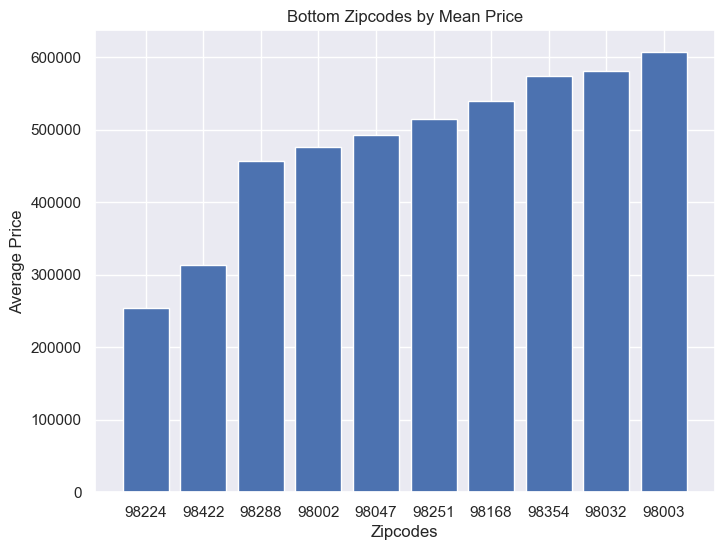

In [47]:
zip_bot_10 = zip_info.sort_values('zip_mean', ascending=True)[0:10]

fig, ax = plt.subplots(figsize=(8,6))

x = zip_bot_10['zip']
y = zip_bot_10['zip_mean']

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Average Price")
ax.set_title("Bottom Zipcodes by Mean Price")

ax.bar(x,y)

Similarly to the previous visualization, this visualization gives us a better idea of the housing market in King County. There appear to be a few zip codes with particularly low housing costs; however, housing costs begin to rise quickly when moving out of these regions. It is not surprising that location plays a major role in the housing market.

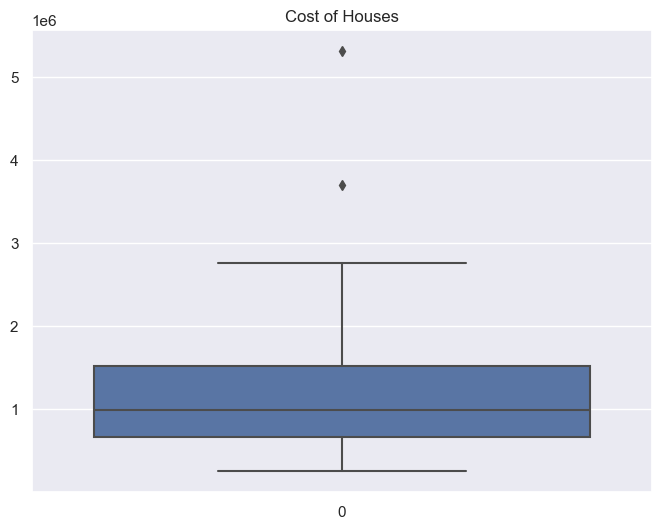

In [51]:
# Create a box plot of average mean
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(zip_info.zip_mean).set(title='Cost of Houses');

Plotting the average prices shows that the mean price of all houses in King County is around 1,000,000.00 USD and that the inner 50 percent sits between roughly 600,000.00 USD and 1,500,000.00 USD. The two highest cost zip codes appear to be outliers compared to the rest of the zip codes, with housing costs over 1,000,000.00 USD more than any other zip code. In regards to budget, it would be the most advised to stay within the inner 50 percent as the housing costs are reasonable. This means that purchasing the property is reasonable and it will be more likely to sell once put on the market because it is within a reasonable price range for the typical home buyer per the average salary in King County (85,416 USD or approximately 170,000 USD for a dual-income household).

Average Salary in King County: https://www.salary.com/research/company/king-county-salary#:~:text=King%20County%20pays%20an%20average,to%20a%20high%20of%20%2497%2C700.

In [52]:
sqft_cat = []

for sqft in df_clean['sqft_living']:
    if sqft < 1000:
        sqft_cat.append(1)
    elif sqft < 1500:
        sqft_cat.append(2)
    elif sqft < 2000:
        sqft_cat.append(3)
    elif sqft < 2500:
        sqft_cat.append(4)
    elif sqft < 3000:
        sqft_cat.append(5)
    elif sqft < 3500:
        sqft_cat.append(6)
    elif sqft < 4000:
        sqft_cat.append(7)
    elif sqft < 4500:
        sqft_cat.append(8)
    else:
        sqft_cat.append(9)
        
df_clean['sqft_cat'] = sqft_cat

In order to accurately analysis the relationship between `price` and `sqft_living`, we seperate `sqft_living` into different categories with a simple loop.

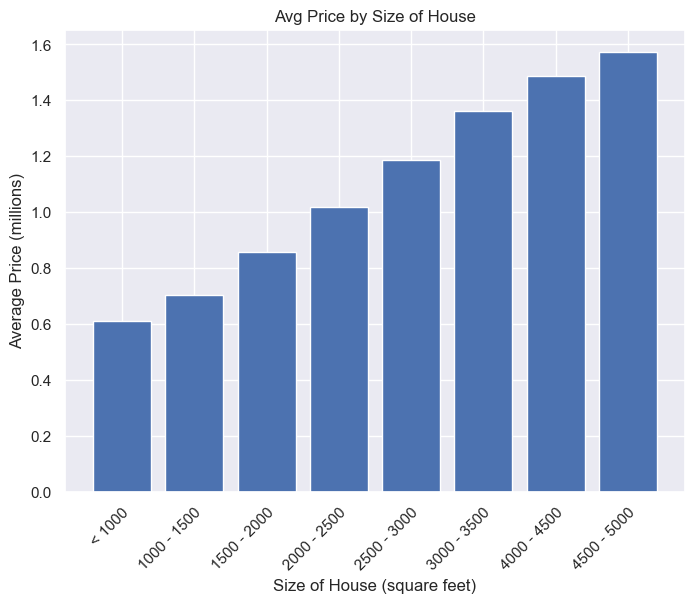

In [57]:
sq_cat_an_price = df_clean[['sqft_cat', 'price']]
sq_cat_an_price = sq_cat_an_price.groupby('sqft_cat').mean('price')

fig, ax = plt.subplots(figsize=(8,6))

x = sq_cat_an_price.index
y = sq_cat_an_price.price/1000000

ax.set_xlabel("Size of House (square feet)")
ax.set_ylabel("Average Price (millions)")
ax.set_title("Avg Price by Size of House")

plt.xticks(np.arange(10), ['', '< 1000', '1000 - 1500','1500 - 2000', 
                          '2000 - 2500', '2500 - 3000', '3000 - 3500',
                          '4000 - 4500', '4500 - 5000', '> 5000'])

plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')

ax.bar(x,y);

As seen in the visualization above, house size has a positive impact on the average price. This is not surprising as bigger houses require more materials and; therefore, cost more. In terms of renovations, it makes sense to add additions to the house in order to increase the overall price of the property.

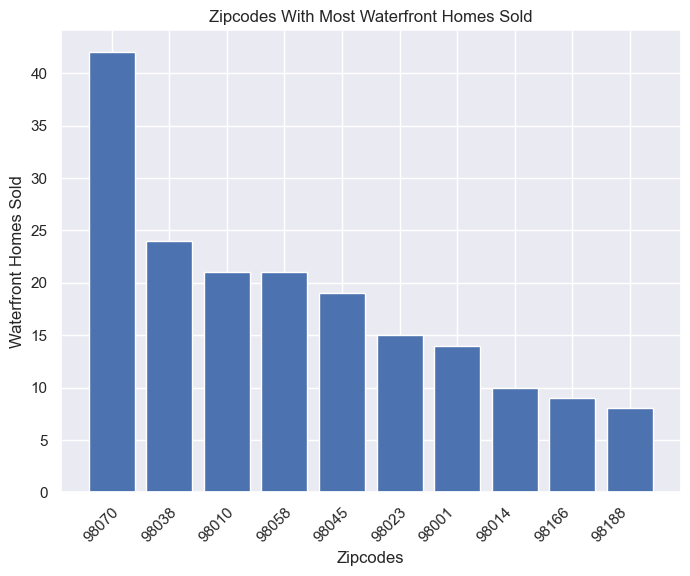

In [59]:
df_zips_an_water = df_clean[['zip', 'waterfront_YES_dum']]
df_zips_water = df_zips_an_water.groupby('zip') \
.sum('waterfront_YES_dum').sort_values('waterfront_YES_dum',
                                       ascending=False)
df_zips_water = df_zips_water[df_zips_water['waterfront_YES_dum'] > 0]
df_zips_water
wat_top_10 = df_zips_water[0:10]

# Create visualization of top 10 zips with watetfront homes sold
fig, ax = plt.subplots(figsize=(8,6))

x = wat_top_10.index
y = wat_top_10['waterfront_YES_dum']

ax.set_xlabel("Zipcodes")
ax.set_ylabel("Waterfront Homes Sold")
ax.set_title("Zipcodes With Most Waterfront Homes Sold")

plt.xticks(rotation=45, ha = 'right', rotation_mode = 'anchor')

ax.bar(x,y);

In our first model, we found that waterfront homes have a positive relationship with `price`. However, as can be seen above, there are a highly limited number of waterfront homes that were recently sold. Therefore; we cannot make recommendations based on this feature as it is very limiting.

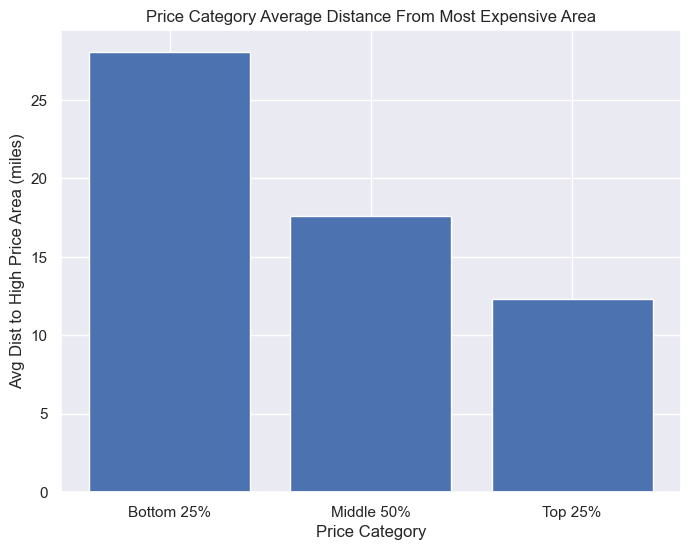

In [61]:
price_an_dist = df_clean[['price_cat', 'dist_high_zip']]
pricecat_dist = price_an_dist.groupby('price_cat').mean('dist_high_zip')

# Visualize

fig, ax = plt.subplots(figsize=(8,6))

x = pricecat_dist.index
y = pricecat_dist['dist_high_zip']

ax.set_xlabel("Price Category")
ax.set_ylabel("Avg Dist to High Price Area (miles)")
ax.set_title("Price Category Average Distance From Most Expensive Area")

# ha = ['right', 'center', 'left']

plt.xticks(np.arange(4), ['', 'Bottom 25%', 'Middle 50%', 'Top 25%'])

ax.bar(x,y);

Above we can see the average distance from the most expensive area in King County, Medina, appears to affect the `price`. The bottom 25 percent of properties are, on average, further away from Medina than the middle 50 percent and same goes for the middle 50 and top 25. Given this information, it appears that the closer to Medina, the higher the prices. This can indicate higher buying costs but also higher potential returns.

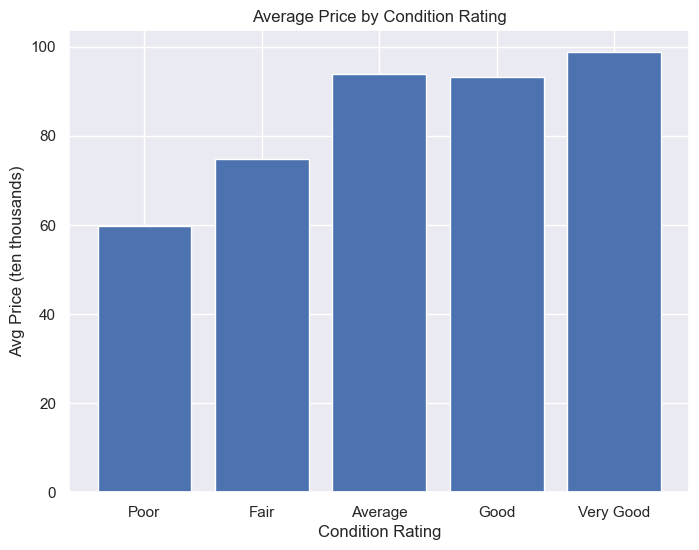

In [63]:
# Create visualization of averge price by condition rating

price_an_cond = df_clean[['cond_enc', 'price']]
price_cond = price_an_cond.groupby('cond_enc').mean('price')

fig, ax = plt.subplots(figsize=(8,6))

x = price_cond.index
y = price_cond['price']/10000

ax.set_xlabel("Condition Rating")
ax.set_ylabel("Avg Price (ten thousands)")
ax.set_title("Average Price by Condition Rating")

# ha = ['right', 'center', 'left']

plt.xticks(np.arange(5), ['Poor', 'Fair', 'Average','Good','Very Good'])

ax.bar(x,y)

plt.savefig('images/ang_price_cond.png', bbox_inches='tight', dpi=300)

The last important feature to mention is the home's condition rating. On average, the cost of homes above an average condition rating does not appear to increase much. The largest price increase occurs between fair and average and then poor and fair. The most significant in terms of renovations is fair to average as poor condition homes are defined as: "End of effective age; major structural and functional deficiencies" and would likely come with massive renovation and restoration costs.

## Conclusion